In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.special import factorial as ss
from pylab import rcParams
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from numpy import log
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA



In [6]:
pip install pdarima

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pdarima (from versions: none)
ERROR: No matching distribution found for pdarima


# Data 

In [116]:
df = pd.read_csv("AMZN.csv", header=0)
df = df.drop(["Open", "High","Low","Adj Close","Volume"], axis=1)
df['Date'] =pd.to_datetime(df['Date'])
print(df.dtypes)
print(df)

Date     datetime64[ns]
Close           float64
dtype: object
           Date        Close
0    2016-04-29   659.590027
1    2016-05-02   683.849976
2    2016-05-03   671.320007
3    2016-05-04   670.900024
4    2016-05-05   659.090027
...         ...          ...
1253 2021-04-22  3309.040039
1254 2021-04-23  3340.879883
1255 2021-04-26  3409.000000
1256 2021-04-27  3417.429932
1257 2021-04-28  3458.500000

[1258 rows x 2 columns]


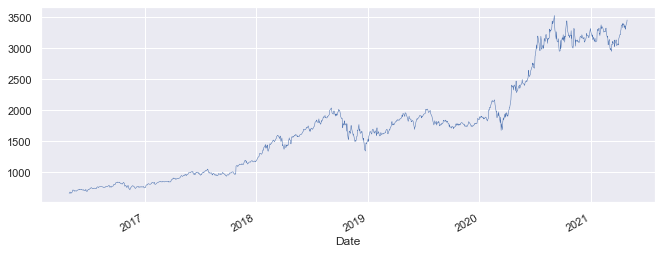

In [117]:
df = df.set_index('Date')
sns.set(rc={'figure.figsize':(11, 4)})
df['Close'].plot(linewidth=0.5);
plt.show()

# Benzi Boillinger

Benzile Boillinger sunt folosite pentru a definii un posibil high sau low in preturile de pe piata bursiera. Acestea sunt un indicator de volatilitate Benzile sunt, de fapt, linii MA - inferioare si superioare = se adauga sau se scade deviatia standard. 

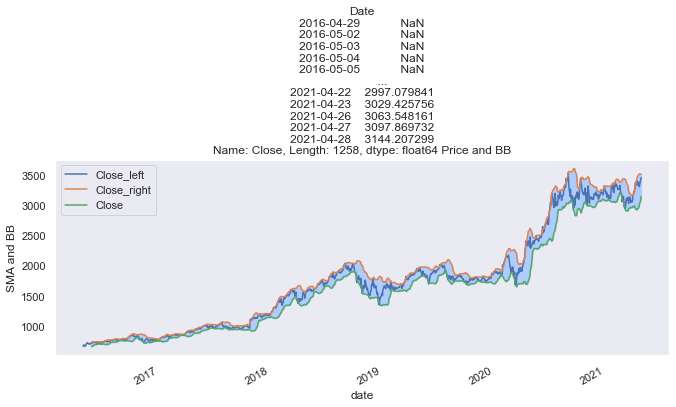

In [118]:
# calculam media mobila pentru 20 de zile
sma = df["Close"].rolling(window=20).mean()
# calculam standard deviation
rstd = df["Close"].rolling(window=20).std()
upper_band = sma + 2 * rstd
lower_band = sma - 2 * rstd
df = df.join(upper_band, on = 'Date',how='left', lsuffix='_left', rsuffix='_right').join(lower_band, on = 'Date',how='left', lsuffix='_left', rsuffix='_right')
ax = df.plot(title='{} Price and BB'.format(df['Close']))
ax.fill_between(df.index, lower_band, upper_band, color='#ADCCFF')
ax.set_xlabel('date')
ax.set_ylabel('SMA and BB')
ax.grid()
plt.show()

Interpretare:
Aproximativ 90% dintre preturile Amazon sunt cuprinse de aceste benzi. Putem folosi aceasta metoda pentru a identifica daca o actiune este sub-apreciata sau supra-apreciata. Daca se afla peste limita superioara -> este supra-apreciata avem un short pe piata. Daca se afla sub linia inferioara -> este sub apreciata avem un long.

# AUTOCORELATIA SI CORELATIA PARTIALA

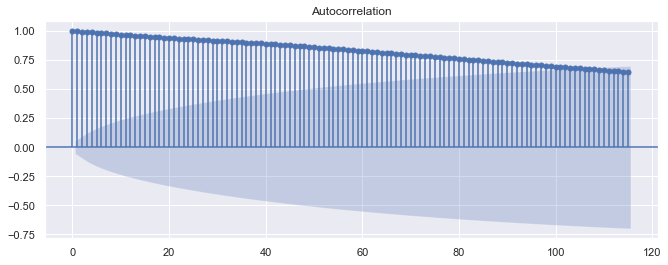

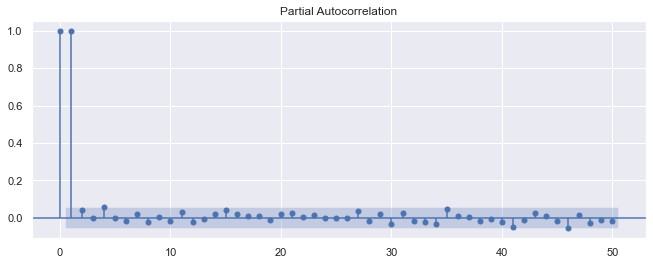

In [10]:
df2 = df.drop(['Close_right', 'Close'], axis=1)
plot_acf(df2["Close_left"],lags=115)
pyplot.show()
plot_pacf(df2, lags=50)
pyplot.show()

In [11]:
print(df2.isna().any())
print(df2)

Close_left    False
dtype: bool
             Close_left
Date                   
2016-04-29   659.590027
2016-05-02   683.849976
2016-05-03   671.320007
2016-05-04   670.900024
2016-05-05   659.090027
...                 ...
2021-04-22  3309.040039
2021-04-23  3340.879883
2021-04-26  3409.000000
2021-04-27  3417.429932
2021-04-28  3458.500000

[1258 rows x 1 columns]


# Decomposition

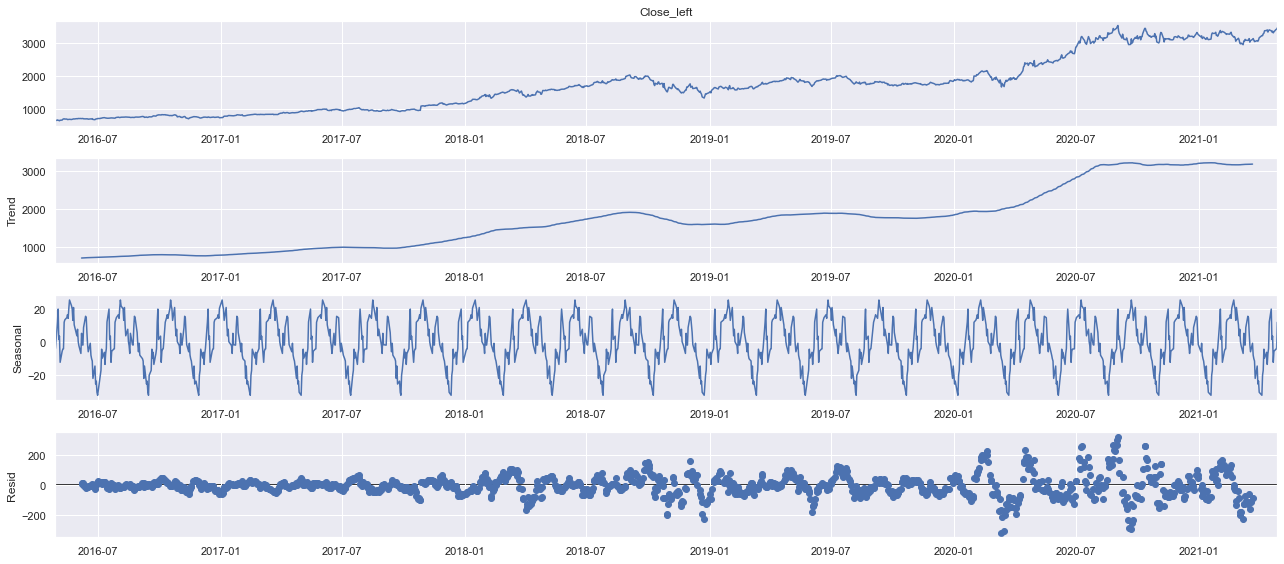

In [12]:
rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(x=df2['Close_left'],  period = 52 , model = 'additive')
fig = decomposition.plot()
plt.show()

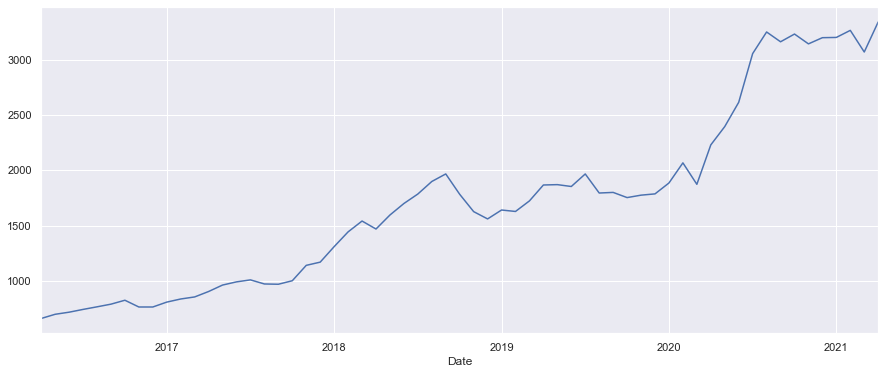

In [13]:
monthly_mean =df2['Close_left'].resample('M').mean()
monthly_mean.plot(figsize=(15, 6))
plt.show()

# Logaritmare

In [14]:
import math
X = df2['Close_left']
X = log(X)
X.dropna()
# X.to_csv('log.csv')

Date
2016-04-29    6.491618
2016-05-02    6.527739
2016-05-03    6.509246
2016-05-04    6.508620
2016-05-05    6.490860
                ...   
2021-04-22    8.104413
2021-04-23    8.113989
2021-04-26    8.134174
2021-04-27    8.136644
2021-04-28    8.148590
Name: Close_left, Length: 1258, dtype: float64

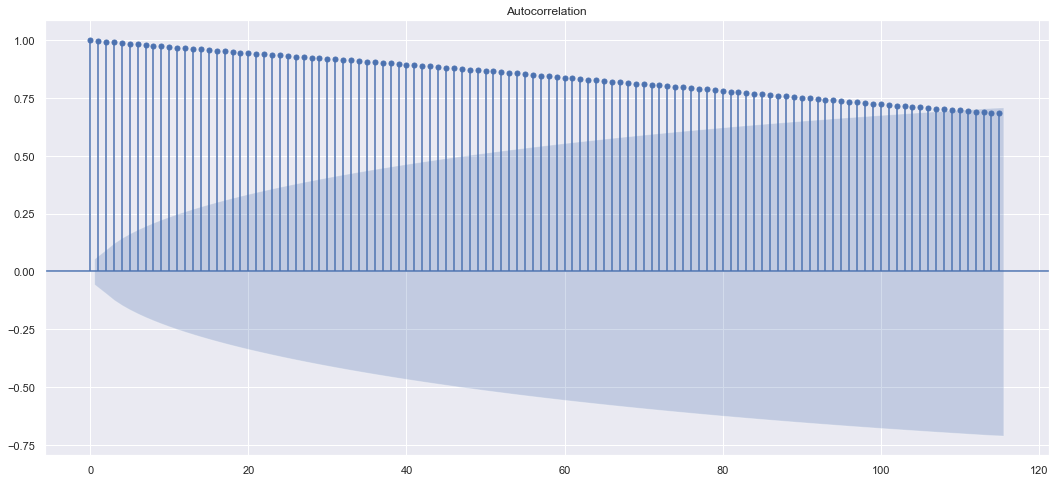

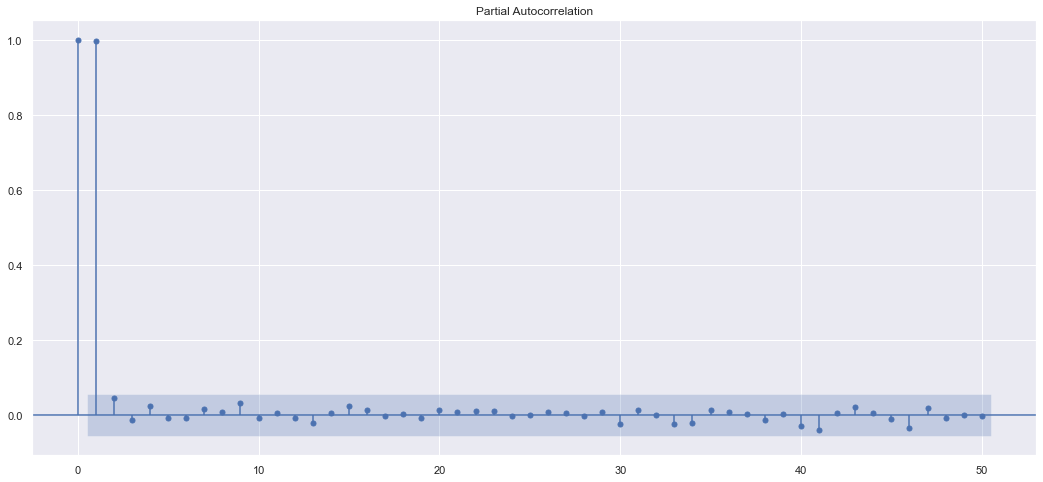

In [15]:
plot_acf(X,lags=115)
pyplot.show()
plot_pacf(X, lags=50)
pyplot.show()

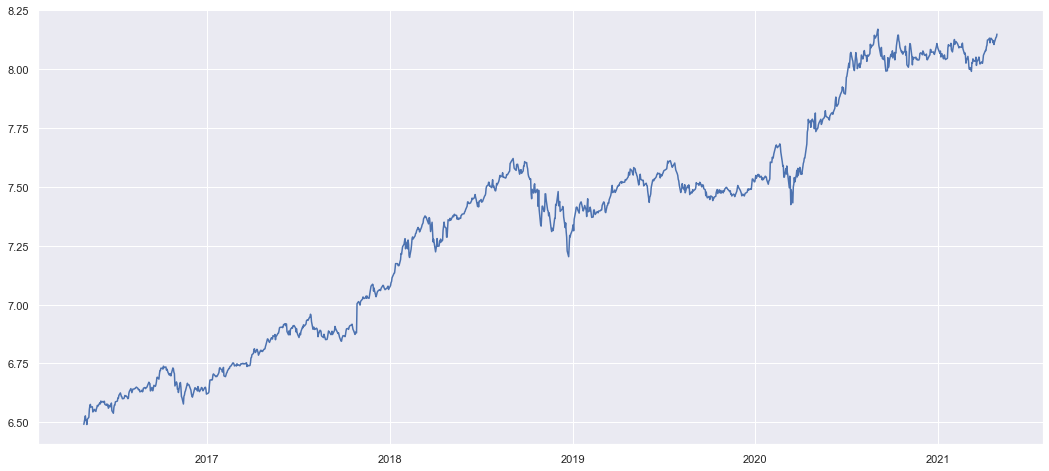

In [16]:
pyplot.plot(X)
pyplot.show()

# Diferentiere

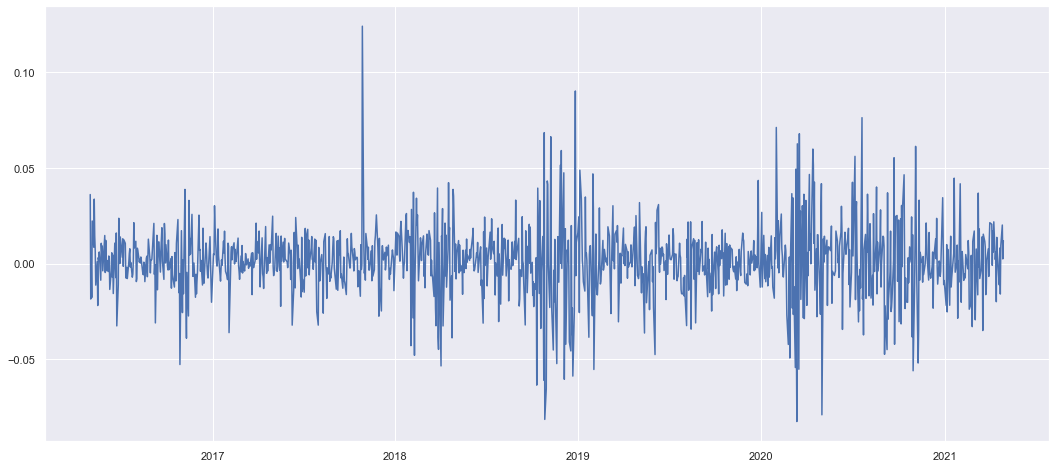

In [17]:
X = X.diff()
X.dropna()

pyplot.plot(X)
pyplot.show()

In [18]:
X = X.iloc[1:]

In [19]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))   

ADF Statistic: -12.461284
p-value: 0.000000
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Autocorelatia si autocorelatia partiala dupa log/diff

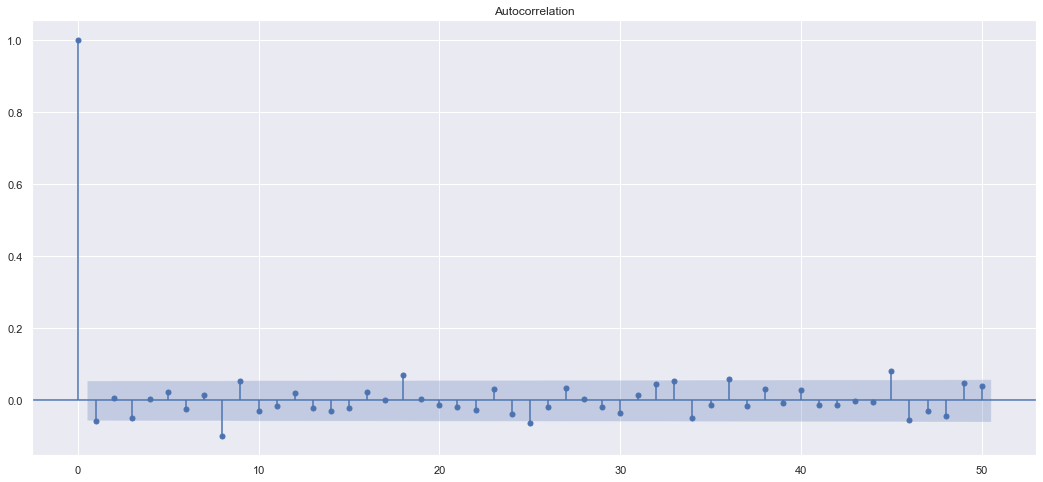

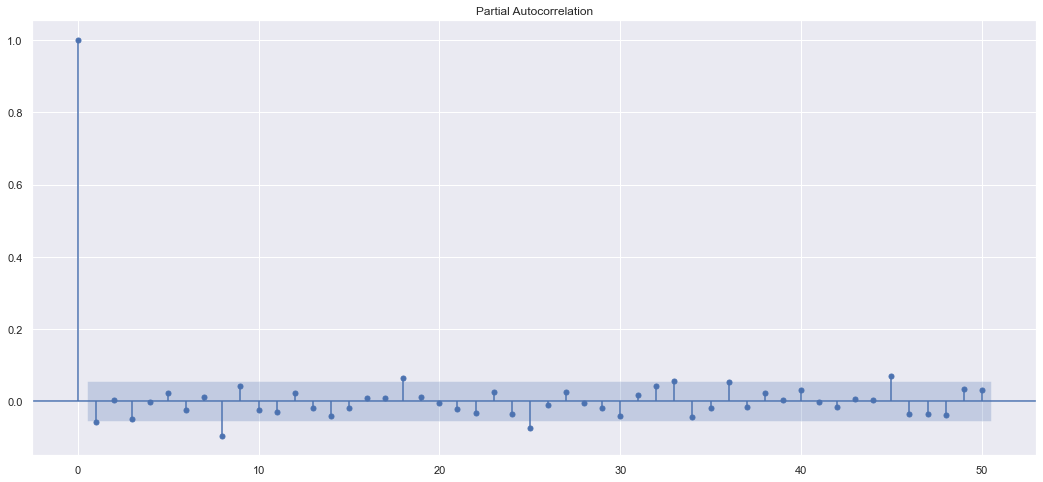

In [20]:
plot_acf(X,lags=50)
pyplot.show()
plot_pacf(X, lags=50)
pyplot.show()

# Train and test

Numar de observatii: 1257
Numar de observatii training: 797
Numar de observatii training testing: 461


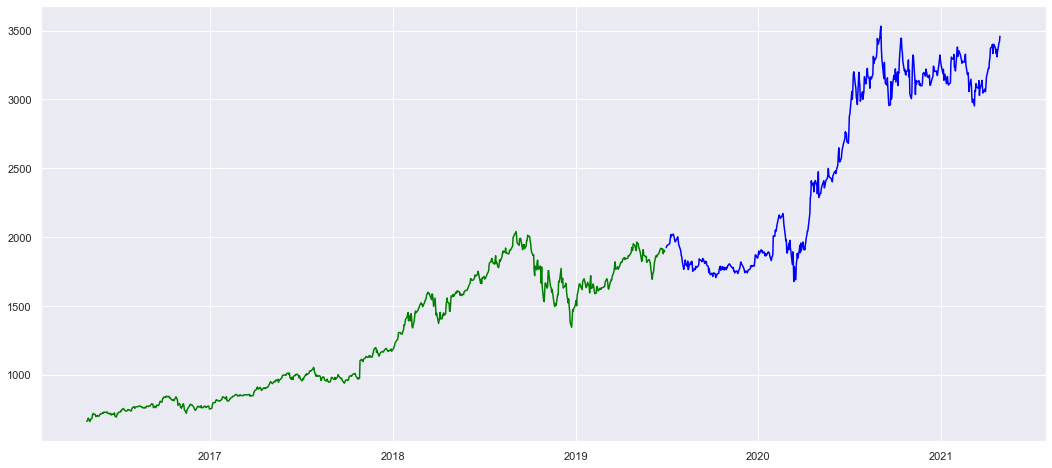

In [21]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df2['Close_left'], train_size=0.634,shuffle=False)
print('Numar de observatii: %d' % (len(X)))
print('Numar de observatii training: %d' % (len(train)))
print('Numar de observatii training testing: %d' % (len(test)))
plt.plot(train, 'green')
plt.plot(test, 'blue')
pyplot.show()

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)


# Rolling mean

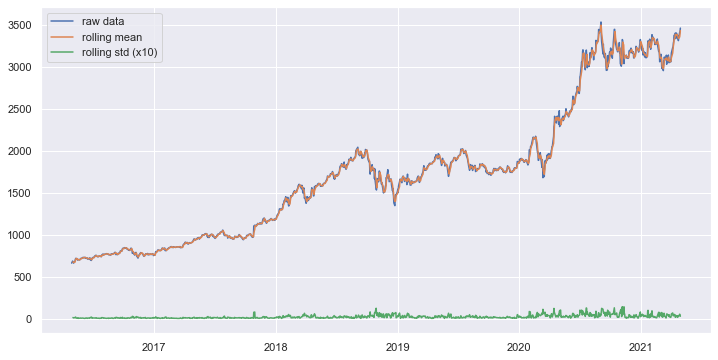

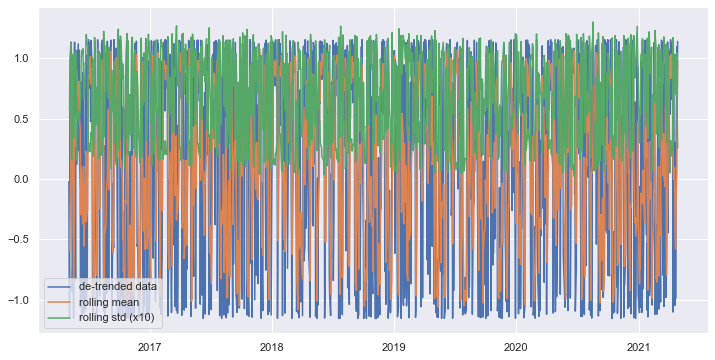

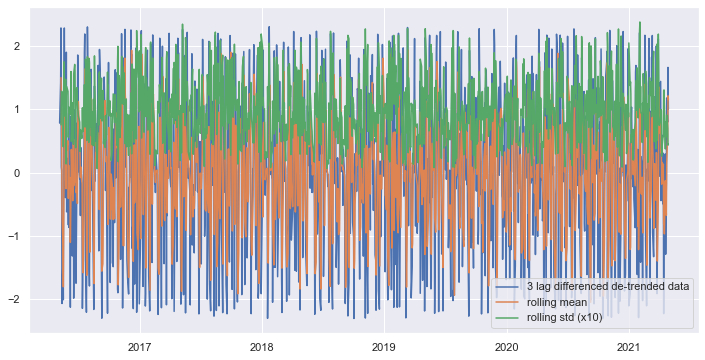

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df2['Close_left'].index, df2['Close_left'], label='raw data')
ax.plot(df2['Close_left'].rolling(window=3).mean(), label="rolling mean")
ax.plot(df2['Close_left'].rolling(window=3).std(), label="rolling std (x10)")
ax.legend()

df2['z_data'] = (df2['Close_left'] - df2['Close_left'].rolling(window=3).mean()) / df2['Close_left'].rolling(window=3).std()
df2['zp_data'] = df2['z_data'] - df2['z_data'].shift(3)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df2.index, df2['z_data'], label="de-trended data")
ax.plot(df2['z_data'].rolling(window=3).mean(), label="rolling mean")
ax.plot(df2['z_data'].rolling(window=3).std(), label="rolling std (x10)")
ax.legend()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df2.index, df2['zp_data'], label="3 lag differenced de-trended data")
ax.plot(df2['zp_data'].rolling(window=3).mean(), label="rolling mean");
ax.plot(df2['zp_data'].rolling(window=3).std(), label="rolling std (x10)");
ax.legend()


# Best ARMA automation

In [ ]:
from statsmodels.tsa.arima_model import ARMA
from pandas import DataFrame
from pylab import rcParams, sqrt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

# evaluate an ARMA model for a given order (p,q)
def evaluate_arma_model(X, arma_order):
    train_size = int(len(X) * 0.634)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARMA(history, order=arma_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for q in q_values:
            order = (p, q)
            try:
                rmse = evaluate_arma_model(dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print('ARMA%s RMSE=%.3f' % (order, rmse))
            except:
                continue
    print('Best ARMA%s RMSE=%.3f' % (best_cfg, best_score))

In [19]:
import warnings
warnings.filterwarnings("ignore")
p = q = range(2) 
evaluate_models(X, p, q)

ARMA(0, 0) RMSE=1196.021
ARMA(0, 1) RMSE=618.204
ARMA(1, 0) RMSE=52.764
Best ARMA(1, 0) RMSE=52.764


# HWE simple and triple

C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-22-3af880ea2afc>:4: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model_seasonal_2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=50, damped=True)
C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aalin\anaconda3\li

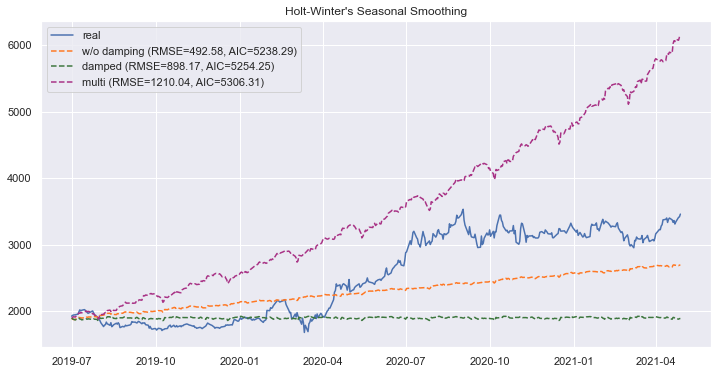

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_seasonal_1 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=50)
model_seasonal_2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=50, damped=True)
#triple HWE
model_seasonal_3 = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=50)
fit = model_seasonal_1.fit()
pred = fit.forecast(461)
fit2 = model_seasonal_2.fit()
pred2 = fit2.forecast(461)
fit3 = model_seasonal_3.fit()
pred3 = fit3.forecast(461)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))
sse3 = np.sqrt(np.mean(np.square(test.values - pred3.values)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test.index, test.values, label='real');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic))
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic))
ax.plot(test.index, pred3, linestyle='--', color='#a83285', label="multi (RMSE={:0.2f}, AIC={:0.2f})".format(sse3, fit3.aic))
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");


# plt.figure(figsize=(16,8))
# plt.plot( train, label='Train')
# plt.plot(test, label='Test')
# plt.plot(pred ,label='Holt_Winter')
# plt.legend(loc='best')
# plt.show()

C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


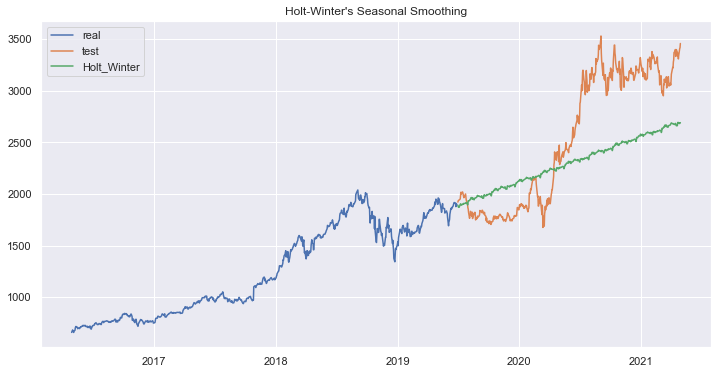

In [23]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=50 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values, label='real')
ax.plot(test.index,test.values, label = 'test')
ax.plot(test.index, y_hat_avg['Holt_Winter'], label = 'Holt_Winter')
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");


# Test models

In [24]:
model00 = ARIMA(df2['Close_left'], order=(0,0,0))
model_fit00 = model00.fit(disp=0)
print(model_fit00.summary())

model10 = ARIMA(df2['Close_left'], order=(1,0,0))
model_fit10 = model10.fit(disp=0)
print(model_fit10.summary())


model01 = ARIMA(df2['Close_left'], order=(0,0,1))
model_fit01 = model01.fit(disp=0)
print(model_fit01.summary())

C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

                              ARMA Model Results                              
Dep. Variable:             Close_left   No. Observations:                 1258
Model:                     ARMA(0, 0)   Log Likelihood              -10195.133
Method:                           css   S.D. of innovations            800.551
Date:                Sun, 06 Jun 2021   AIC                          20394.266
Time:                        21:06:21   BIC                          20404.540
Sample:                             0   HQIC                         20398.127
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1725.3466     22.571     76.441      0.000    1681.108    1769.585
                              ARMA Model Results                              
Dep. Variable:             Close_left   No. Observat

C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

                              ARMA Model Results                              
Dep. Variable:             Close_left   No. Observations:                 1258
Model:                     ARMA(0, 1)   Log Likelihood               -9365.150
Method:                       css-mle   S.D. of innovations            413.374
Date:                Sun, 06 Jun 2021   AIC                          18736.299
Time:                        21:06:23   BIC                          18751.711
Sample:                             0   HQIC                         18742.091
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1725.4324     22.999     75.021      0.000    1680.354    1770.510
ma.L1.Close_left     0.9742      0.005    192.546      0.000       0.964       0.984
                            

# Predict type 1

In [25]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARMA(history, order=(0,1))
    model_fit = model.fit(disp= -1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

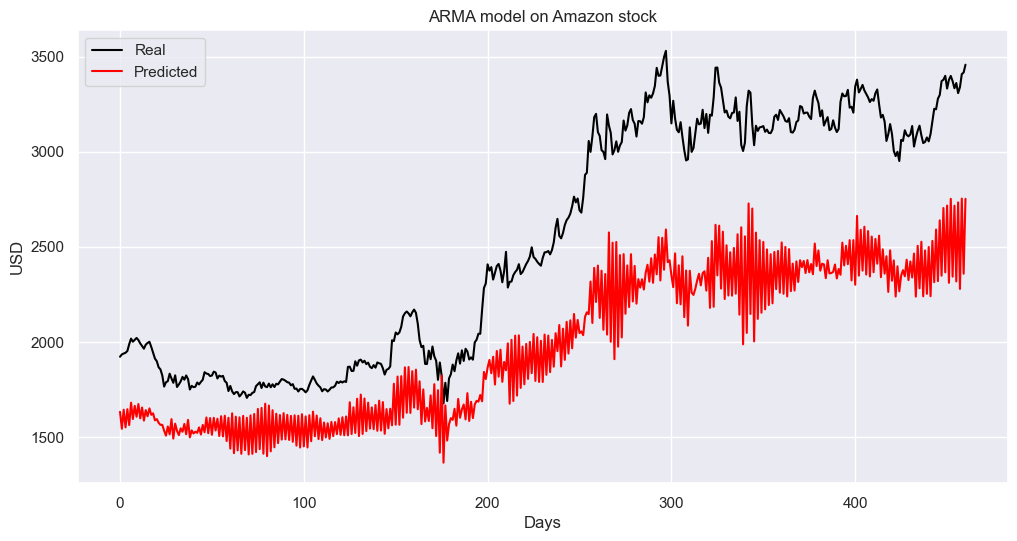

In [29]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test.values, color='black', label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARMA model on Amazon stock')
plt.legend()
plt.show()

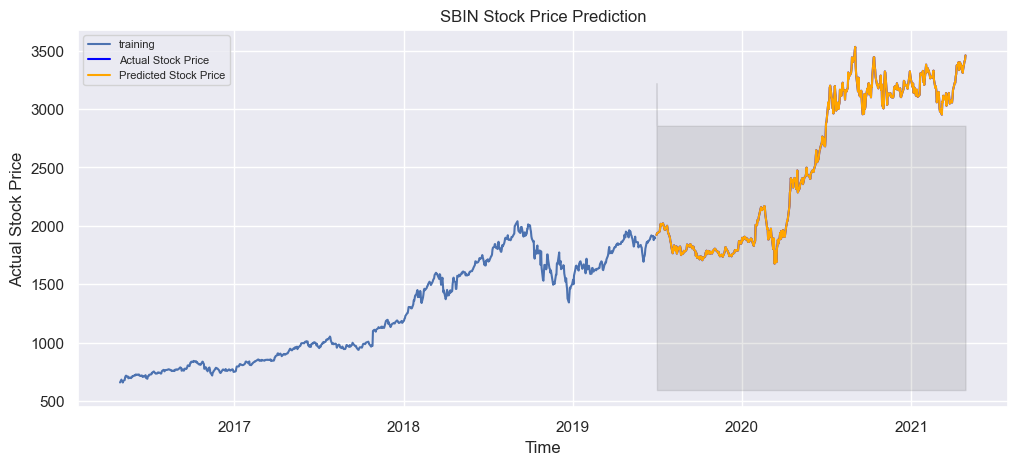

In [33]:
fc, se, conf = model_fit01.forecast(461, alpha=0.05)  # 95% confidence
fc_series = pd.Series(df2["Close_left"], index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('SBIN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
print(model_fit01.aic, model_fit01.bic, model_fit01.hqic)

18736.299189505076 18751.711024816857 18742.091178699688


# Durbin Waston

In [24]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model_fit01.resid.values)

0.14470791061308427

The closer to 0 the statistic, the more evidence for positive serial correlation

# Plot reziduri

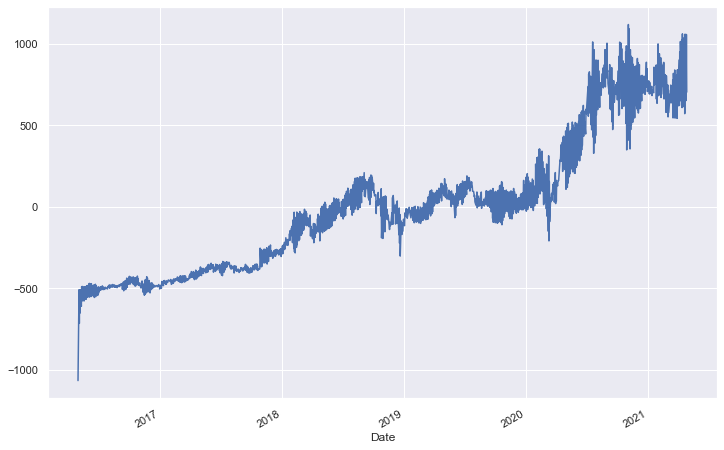

In [25]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = model_fit01.resid.plot(ax=ax);

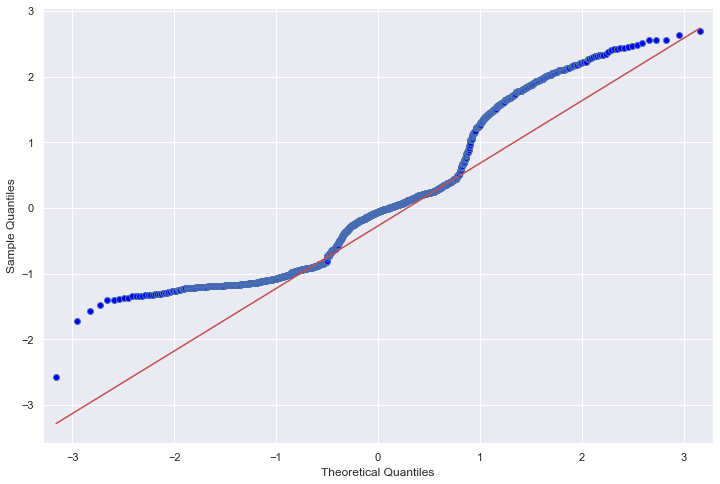

In [27]:
from statsmodels.graphics.gofplots import qqplot
resid = model_fit01.resid
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

AttributeError: module 'statsmodels.graphics' has no attribute 'tsa'

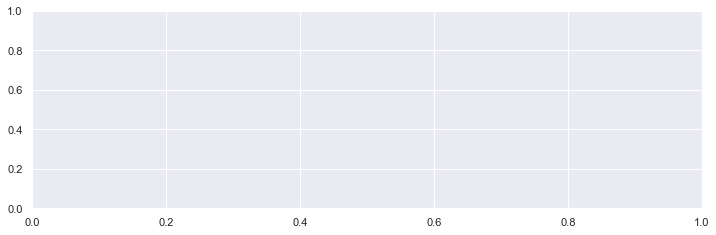

In [80]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [81]:
print(df2)

             Close_left    z_data   zp_data
Date                                       
2016-04-29   659.590027       NaN       NaN
2016-05-02   683.849976       NaN       NaN
2016-05-03   671.320007 -0.021980       NaN
2016-05-04   670.900024 -0.605653       NaN
2016-05-05   659.090027 -1.154172       NaN
...                 ...       ...       ...
2021-04-22  3309.040039 -0.989263 -0.181438
2021-04-23  3340.879883  0.133732  1.180584
2021-04-26  3409.000000  1.097153  0.797976
2021-04-27  3417.429932  0.674849  1.664112
2021-04-28  3458.500000  1.139982  1.006249

[1258 rows x 3 columns]


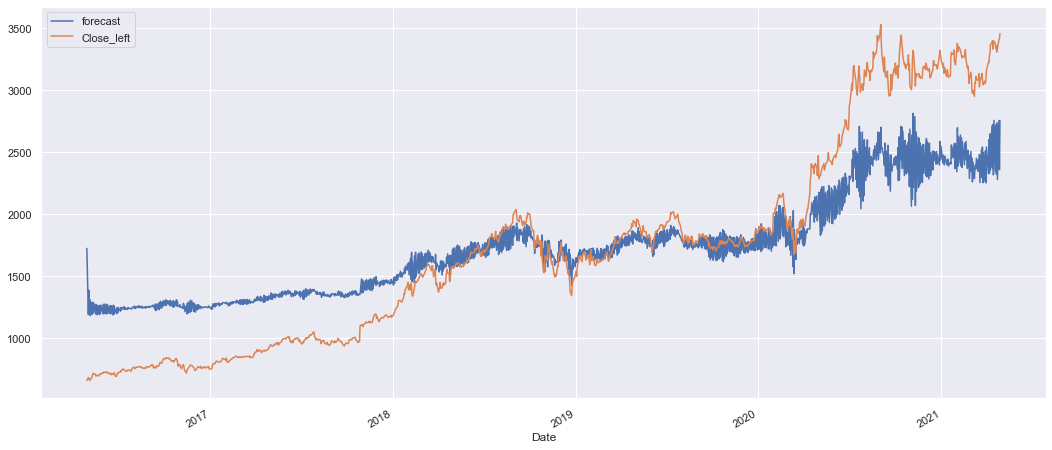

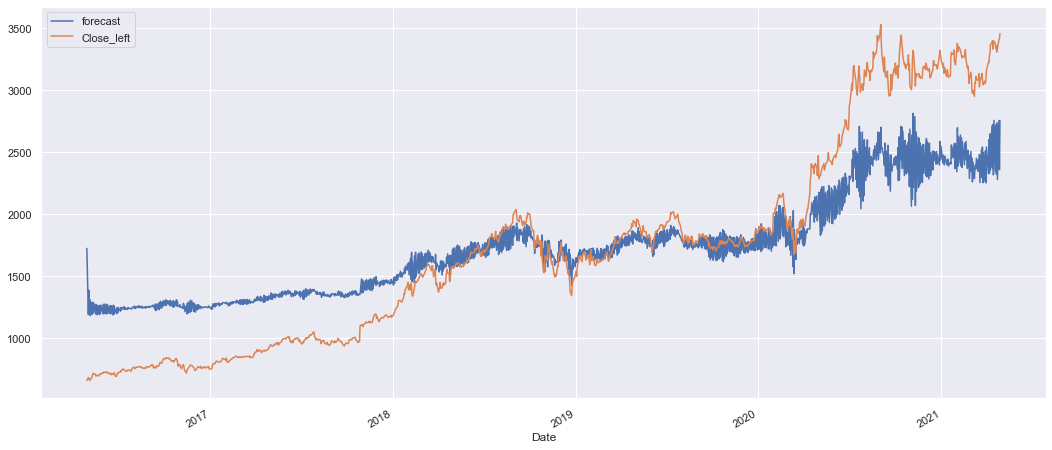

In [38]:
model_fit01.plot_predict()

In [39]:
predictie_arma01 = model_fit01.predict()
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()
mean_forecast_err(df2['Close_left'], predictie_arma01)

-0.4362172980981117

# Testam arch


In [36]:
from statsmodels.stats.diagnostic import het_arch
het_arch(resid)

C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:657: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  warnings.warn("The default value of nlags is changing.  After 0.12, "


(1198.2640224043507, 7.877705377011724e-239, 1717.422805398511, 0.0)

# Modele ARCH si GARCH

In [274]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [97]:
from arch import arch_model
model = arch_model(resid, mean='Zero', vol='ARCH')
model_fit = model.fit()

yhat = model_fit.forecast(horizon=len(test))

print(model_fit.summary())

print(yhat.mean.iloc[-3:])
print(yhat.residual_variance.iloc[-3:])
print(yhat.variance.iloc[-3:])


forecasts =  model_fit.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])

Iteration:      1,   Func. Count:      4,   Neg. LLF: 8880.98406859619
Iteration:      2,   Func. Count:      8,   Neg. LLF: 8879.888513343718
Iteration:      3,   Func. Count:     11,   Neg. LLF: 8879.888496447758
Iteration:      4,   Func. Count:     14,   Neg. LLF: 8879.88841280594
Iteration:      5,   Func. Count:     17,   Neg. LLF: 8879.888291650084
Iteration:      6,   Func. Count:     20,   Neg. LLF: 8879.887542172462
Iteration:      7,   Func. Count:     23,   Neg. LLF: 8879.885558558959
Iteration:      8,   Func. Count:     26,   Neg. LLF: 8879.881478206273
Iteration:      9,   Func. Count:     29,   Neg. LLF: 8879.864650382968
Iteration:     10,   Func. Count:     32,   Neg. LLF: 8879.830629341835
Iteration:     11,   Func. Count:     35,   Neg. LLF: 8879.763404451167
Iteration:     12,   Func. Count:     38,   Neg. LLF: 8879.37276931122
Iteration:     13,   Func. Count:     41,   Neg. LLF: 8878.583843880151
Iteration:     14,   Func. Count:     44,   Neg. LLF: 8877.00211096

C:\Users\aalin\anaconda3\lib\site-packages\arch\univariate\base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.718e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\aalin\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [98]:
from arch.univariate.volatility import (ARCH, GARCH)
from arch.univariate.mean import (ARX, HARX, LS, ConstantMean, ZeroMean,arch_model)
from arch.univariate.distribution import Distribution, Normal
model = ConstantMean(resid)
model.volatility = GARCH(1, 0, 1)
model.distribution = Normal()


res = model.fit()
print(res.summary())

forecasts  = res.forecast(horizon=len(test))

print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])


forecasts =  res.forecast(horizon=5, reindex=False)
print(res.residual_variance.iloc[-3:])

C:\Users\aalin\anaconda3\lib\site-packages\arch\univariate\base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.718e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 37727.82541012601
Iteration:      2,   Func. Count:     12,   Neg. LLF: 8995.751054506905
Iteration:      3,   Func. Count:     18,   Neg. LLF: 8745.959266570242
Iteration:      4,   Func. Count:     24,   Neg. LLF: 8734.97706873051
Iteration:      5,   Func. Count:     29,   Neg. LLF: 8734.653269898827
Iteration:      6,   Func. Count:     34,   Neg. LLF: 8734.63857809826
Iteration:      7,   Func. Count:     39,   Neg. LLF: 8734.626709355074
Iteration:      8,   Func. Count:     44,   Neg. LLF: 8734.597775104436
Iteration:      9,   Func. Count:     49,   Neg. LLF: 8734.5566049928
Iteration:     10,   Func. Count:     54,   Neg. LLF: 8734.518595299072
Iteration:     11,   Func. Count:     59,   Neg. LLF: 8734.502733955474
Iteration:     12,   Func. Count:     64,   Neg. LLF: 8734.500416716757
Iteration:     13,   Func. Count:     69,   Neg. LLF: 8734.500139964315
Iteration:     14,   Func. Count:     74,   Neg. LLF: 8734.499614082

C:\Users\aalin\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


AttributeError: 'ARCHModelResult' object has no attribute 'residual_variance'

In [93]:
def evaluate_arima_model(X, arima_order):
    train, test= train_test_split(df2['Close_left'], train_size=0.634,shuffle=False)
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_arima(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue 
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [94]:
import warnings
warnings.filterwarnings("ignore")
p = q = d = range(2) 
evaluate_models_arima(train, p, d, q)

ARIMA(0, 0, 0) RMSE=1196.021
ARIMA(0, 0, 1) RMSE=618.204
ARIMA(0, 1, 0) RMSE=52.643
ARIMA(0, 1, 1) RMSE=52.612
ARIMA(1, 0, 0) RMSE=52.753
ARIMA(1, 1, 0) RMSE=52.615
ARIMA(1, 1, 1) RMSE=52.639
Best ARIMA(0, 1, 1) RMSE=52.612


In [37]:
mod_arima011 = ARIMA(df2['Close_left'], order=(0,1,1))
model_fit011 = mod_arima011.fit(disp=0)
print(model_fit011.summary())


mod_arima110 = ARIMA(df2['Close_left'], order=(1,1,0))
model_fit110 = mod_arima110.fit(disp=0)
print(model_fit110.summary())


                             ARIMA Model Results                              
Dep. Variable:           D.Close_left   No. Observations:                 1257
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6339.137
Method:                       css-mle   S.D. of innovations             37.492
Date:                Fri, 07 May 2021   AIC                          12684.275
Time:                        10:27:14   BIC                          12699.684
Sample:                             1   HQIC                         12690.066
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.2236      0.991      2.245      0.025       0.282       4.165
ma.L1.D.Close_left    -0.0633      0.028     -2.229      0.026      -0.119      -0.008
                    

In [38]:
print(model_fit110.aic, model_fit110.bic, model_fit110.hqic)

12684.274007701642 12699.683457327414 12690.065328344803


In [39]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model_fit110.resid.values)

1.9984648604837718

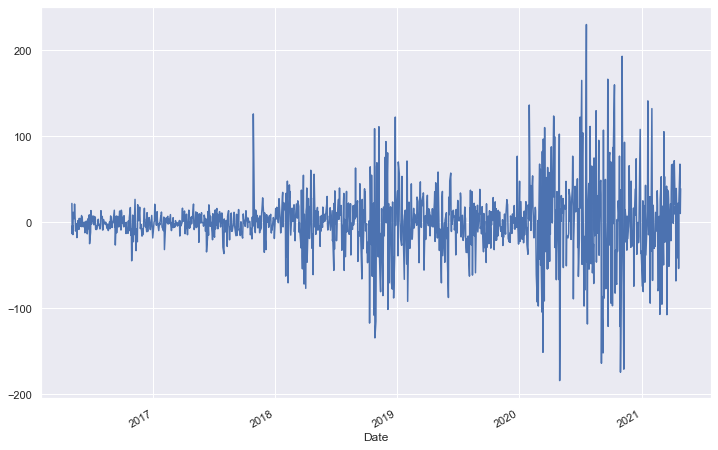

In [41]:
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(111)
ax1 = model_fit110.resid.plot(ax=ax1);

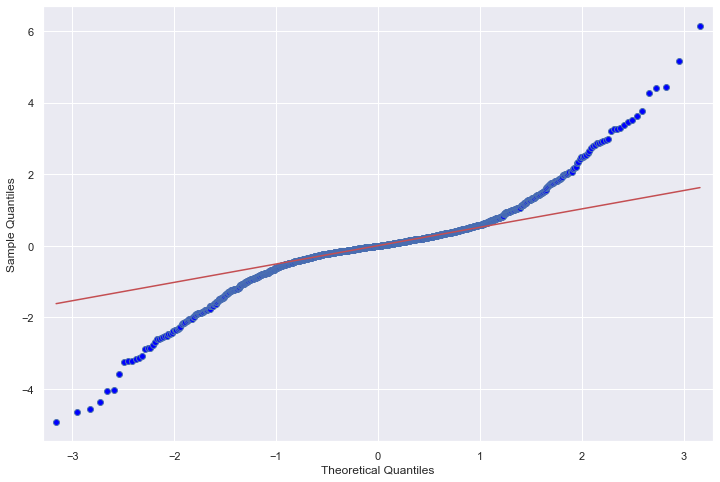

In [42]:
from statsmodels.graphics.gofplots import qqplot
resid110 = model_fit110.resid
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid110, line='q', ax=ax, fit=True)

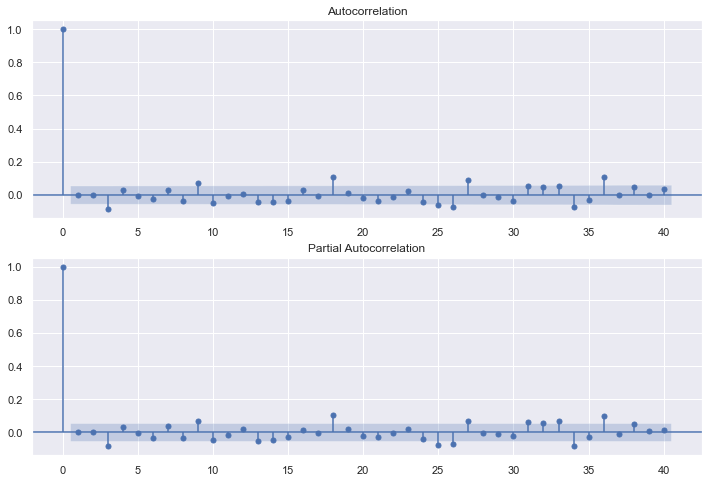

In [43]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid110.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid110, lags=40, ax=ax2)

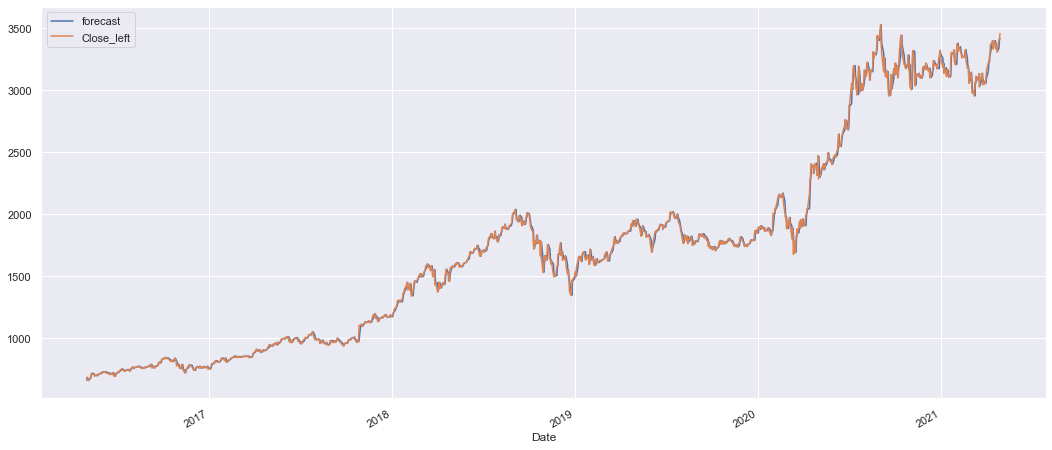

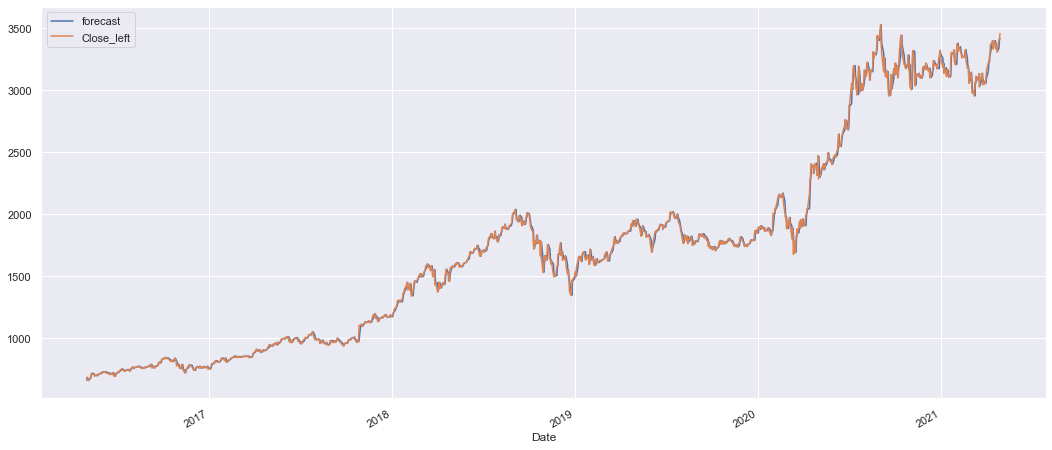

In [44]:
model_fit110.plot_predict()

In [45]:
predictie_arima110 = model_fit110.predict()
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()
mean_forecast_err(df2['Close_left'], predictie_arima110)

1723.9688946982421

# SARIMA

In [16]:
from itertools import product
def optimize_SARIMA(parameters_list, d, D, s, exog):
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 2
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

16


In [22]:
from tqdm import tqdm_notebook
result_df = optimize_SARIMA(parameters_list, 1, 1, 2, df2['Close_left'])
result_df

<ipython-input-16-eafc5a45f4dc>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [ ]:
#arima 010 100 3

C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                     
Dep. Variable:                        Close_left   No. Observations:                 1258
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 3)   Log Likelihood               -6339.186
Date:                           Thu, 03 Jun 2021   AIC                          12682.371
Time:                                   17:48:40   BIC                          12692.644
Sample:                                        0   HQIC                         12686.232
                                          - 1258                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L3       -0.0859      0.016     -5.521      0.000      -0.116      -0.055
sigma2      1408.5016     29.688     47.443

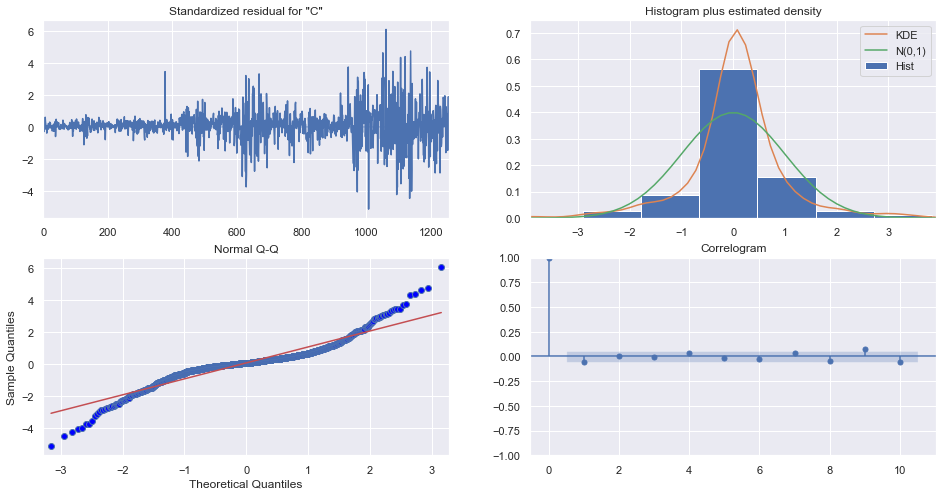

In [21]:
import statsmodels.api as sm
mod_sarima1 = sm.tsa.statespace.SARIMAX(df2['Close_left'], order=(0, 1, 0), seasonal_order=(1, 0, 0, 3)).fit(dis=-1)
print(mod_sarima1.summary())
mod_sarima1.plot_diagnostics(figsize=(16, 8))
plt.show()

In [23]:
mod_sarima1.forecast(1)
#3452.64665	

C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


1258    3452.64665
dtype: float64

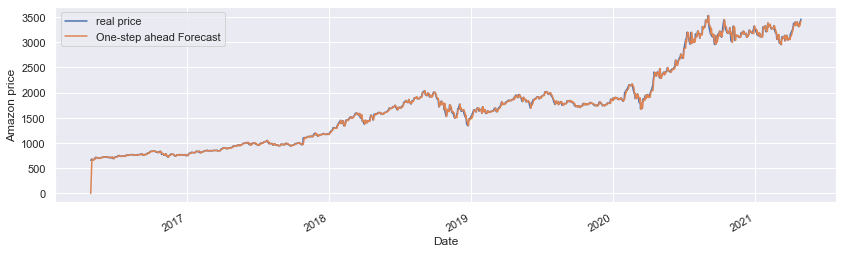

In [24]:
pred = mod_sarima1.rint(start=pd.to_datetime('2016-04-29'), dynamic=False)
pred_ci = pred.conf_int()
ax = df2['Close_left'].plot(label='real price')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=1, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Amazon price')
plt.legend()
plt.show()

# State space models

In [100]:
from __future__ import division, absolute_import, print_function

import numpy as np
import statsmodels.api as sm

class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, **kwargs):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef, **kwargs
        )

        # Initialize the matrices
        self['design'] = np.r_[1, 0]
        self['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self['selection'] = np.eye(k_states)

        # Initialize the state space model as approximately diffuse
        self.initialize_approximate_diffuse()
        # Because of the diffuse initialization, burn first two
        # loglikelihoods
        self.loglikelihood_burn = 2
        
        # Cache some indices
        idx = np.diag_indices(k_posdef)
        self._state_cov_idx = ('state_cov', idx[0], idx[1])
        
        # Setup parameter names
        self._param_names = ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        # Simple start parameters: just set as 0.1
        return np.r_[0.1, 0.1, 0.1]

    def transform_params(self, unconstrained):
        # Parameters must all be positive for likelihood evaluation.
        # This transforms parameters from unconstrained parameters
        # returned by the optimizer to ones that can be used in the model.
        return unconstrained**2

    def untransform_params(self, constrained):
        # This transforms parameters from constrained parameters used
        # in the model to those used by the optimizer
        return constrained**0.5

    def update(self, params, **kwargs):
        # The base Model class performs some nice things like
        # transforming the params and saving them
        params = super(LocalLinearTrend, self).update(params, **kwargs)

        # Extract the parameters
        measurement_variance = params[0]
        level_variance = params[1]
        trend_variance = params[2]

        # Observation covariance
        self['obs_cov', 0, 0] = measurement_variance

        # State covariance
        self[self._state_cov_idx] = [level_variance, trend_variance]

In [102]:
logg = np.log(df2['Close_left'])
# Setup the model
mod = LocalLinearTrend(logg)
res = mod.fit()
print(res.summary())

C:\Users\aalin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                           Statespace Model Results                           
Dep. Variable:             Close_left   No. Observations:                 1258
Model:               LocalLinearTrend   Log Likelihood                3241.216
Date:                Thu, 13 May 2021   AIC                          -6476.432
Time:                        22:59:20   BIC                          -6461.025
Sample:                             0   HQIC                         -6470.642
                               - 1258                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement  1.984e-05   6.66e-06      2.978      0.003    6.78e-06    3.29e-05
sigma2.level           0.0003   1.49e-05     19.859      0.000       0.000       0.000
sigma2.trend        

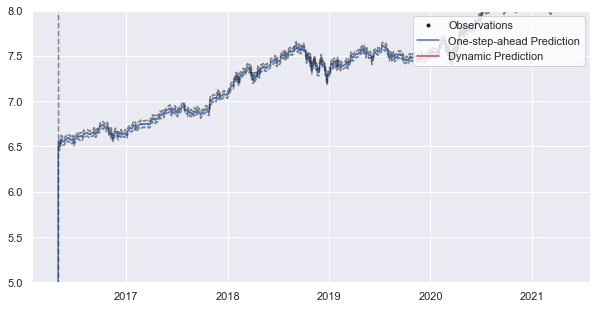

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))

# Perform dynamic prediction and forecasting
ndynamic = 5
predict_res = res.get_prediction(alpha=0.05, dynamic=df2['Close_left'].shape[0]-ndynamic)

predict = predict_res.predicted_mean
ci = predict_res.conf_int(alpha=0.05)

# Plot the results
ax.plot(df2['Close_left'], 'k.', label='Observations');
ax.plot(df2.index[:-ndynamic], predict[:-ndynamic], label='One-step-ahead Prediction');
ax.plot(df2.index[:-ndynamic], ci.iloc[:-ndynamic], 'k--', alpha=0.5);

ax.plot(df2.index[-ndynamic:], predict[-ndynamic:], 'r', label='Dynamic Prediction');
ax.plot(df2.index[-ndynamic:], ci.iloc[-ndynamic:], 'k--', alpha=0.5);

# Cleanup the image
ax.set_ylim((5, 8));
legend = ax.legend(loc='upper right');
legend.get_frame().set_facecolor('w')


# GARCH multivariat

In [29]:
dataset2 = pd.read_csv("nasdaq.csv", header=0 )
df3 = dataset2
# print(df3.dtypes)
# df3['Date'] =pd.to_datetime(df3['Date'])
# df3 = df3.sort_values(by="Date")
# print(df3.dtypes)

In [28]:
print(df3)

                   Close
Date                    
2016-01-06   4952.250000
2016-01-07   4862.569824
2016-01-08   5184.200195
2016-01-09   5227.209961
2016-01-11   5153.580078
...                  ...
2021-11-03  13398.669920
2021-12-01  13072.429690
2021-12-02  14095.469730
2021-12-03  13319.860350
2021-12-04  13850.000000

[1266 rows x 1 columns]


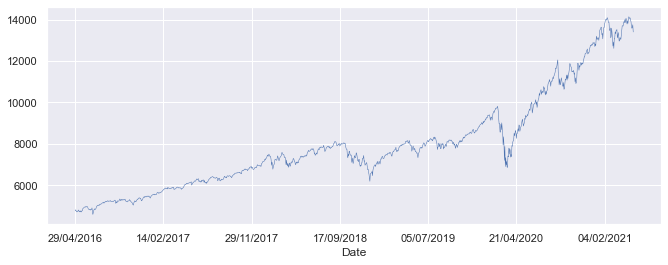

In [30]:
df3 = df3.set_index('Date')
sns.set(rc={'figure.figsize':(11, 4)})
df3['Close'].plot(linewidth=0.5);
plt.show()

In [87]:
result = adfuller(df3['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))   

ADF Statistic: -11.188561
p-value: 0.000000
	1%: -3.436
	5%: -2.864
	10%: -2.568


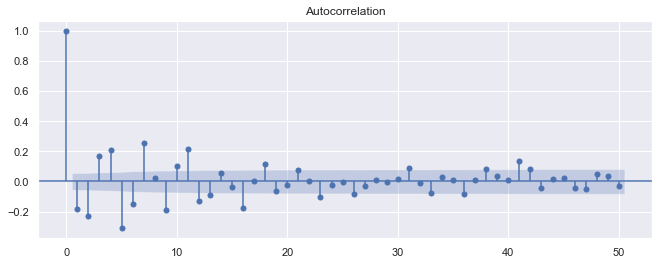

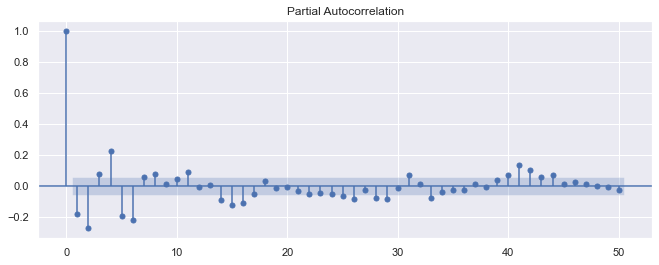

In [88]:
plot_acf(df3['Close'],lags=50)
pyplot.show()
plot_pacf(df3['Close'], lags=50)
pyplot.show()

# State Space Models

In [4]:
import sympy as sym
parameter_symbols = \
    sym.symbols(('alpha.mu',
                 'beta.mu',
                 'sigma',
                 'sigma.mu'))

alpha_mu, beta_mu, sigma, sigma_mu = parameter_symbols

In [5]:
H = sym.Matrix([sigma**2])
Q = sym.Matrix([sigma_mu**2])
c = sym.Matrix([alpha_mu])
T = sym.Matrix([beta_mu])
Z = sym.Matrix.ones(rows=1, cols=1)
R = sym.Matrix.ones(rows=1, cols=1)

In [6]:
state_vector_symbols = tuple([sym.Symbol('mu')])

In [7]:
y = sym.Symbol('y')
data_symbol_to_data_map = {y: df['Close']}

In [8]:
parameter_symbols_to_start_parameters_map = \
    {alpha_mu: 0.0,
     beta_mu: 0.0,
     sigma: 0.001,
     sigma_mu: 0.001}

In [39]:
pip install state_space

Note: you may need to restart the kernel to use updated packages.


In [9]:
import state_space as ss
from state_space import (
    SymbolicStateSpaceModelViaMaximumLikelihood, 
    IndependentParameterTransformation, 
    LambdaUnivariateTransformation, 
    RectangularParameterTransformation)

squared_univariate_transform = \
    LambdaUnivariateTransformation(
        transform_function=lambda x: x**2,
        untransform_function=lambda x: x**0.5)

parameter_transformation = \
    IndependentParameterTransformation(
        parameter_symbols=parameter_symbols,
        parameter_symbol_to_univariate_transformation_map
        ={sigma: squared_univariate_transform,
          sigma_mu: squared_univariate_transform})

In [10]:
time_varying_equity_premium_model = \
    SymbolicStateSpaceModelViaMaximumLikelihood(parameter_symbols=parameter_symbols,
                                                state_vector_symbols=state_vector_symbols,
                                                observation_vector_symbols=tuple([y]),
                                                data_symbol_to_data_map=data_symbol_to_data_map,
                                                parameter_symbols_to_start_parameters_map
                                                =parameter_symbols_to_start_parameters_map,
                                                parameter_transformation=parameter_transformation,
                                                design_matrix=Z,
                                                selection_matrix=R,
                                                transition_matrix=T,
                                                state_intercept_vector=c,
                                                state_covariance_matrix=Q,
                                                observation_covariance_matrix=H)

In [42]:
result = time_varying_equity_premium_model.fit(disp=False)
print(result.summary())

                                        Statespace Model Results                                       
Dep. Variable:                                               y   No. Observations:                 1257
Model:             SymbolicStateSpaceModelViaMaximumLikelihood   Log Likelihood                3247.333
Date:                                         Thu, 20 May 2021   AIC                          -6486.665
Time:                                                 23:14:03   BIC                          -6466.123
Sample:                                                      0   HQIC                         -6478.944
                                                        - 1257                                         
Covariance Type:                                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
alpha.mu  

In [43]:
plt.plot(X3, result.filtered_state[0, :])

NameError: name 'X3' is not defined

In [ ]:
plt.plot(X, result.smoothed_state[0, :]);

# Analiza spectrala

In [68]:
pip install pyts

Note: you may need to restart the kernel to use updated packages.


In [72]:
x = pd.Series(X)
x = np.array(x)
print(x)

[ 0.03612009 -0.01849263 -0.0006258  ...  0.02018478  0.00246979
  0.01194618]


In [83]:
import numpy as np
from pyts.decomposition import SingularSpectrumAnalysis
# We decompose the time series into three subseries

x = x.reshape(-1,1) 
window_size = 10
groups = [np.arange(i, i + 5) for i in range(0, 1257, 10)]
ssa = SingularSpectrumAnalysis(window_size=10, groups=groups)
X_ssa = ssa.fit_transform(x)

ValueError: If 'window_size' is an integer, it must be greater than or equal to 2 and lower than or equal to n_timestamps (got 10).

# Deep learning

In [48]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.5.0-cp38-cp38-win_amd64.whl (422.6 MB)


In [49]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [50]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close_left,1258.0,1725.346556,800.869722,659.090027,978.937500,1697.549988,1964.377503,3531.449951
Close_right,1239.0,1823.029549,842.250397,730.641203,1019.760139,1798.937957,2065.464739,3610.615164
Close,1239.0,1618.387081,734.418248,656.364674,940.689254,1592.880469,1830.814417,3213.370821


In [80]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df['Close'][0:int(n*0.7)]
val_df = df['Close'][int(n*0.7):int(n*0.9)]
test_df = df['Close'][int(n*0.9):]

num_features = df.shape[1]

In [81]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [82]:
df_std = ( df['Close'] - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

AttributeError: 'Series' object has no attribute 'melt'

In [73]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [79]:
w1 = WindowGenerator(input_width=7, label_width=1, shift=1,
                    label_columns=['T (degC)'])
w1

AttributeError: 'Series' object has no attribute 'columns'

In [75]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [68]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

KeyError: 'price'

In [54]:
import time
import numpy as np


import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import accuracy_score

In [59]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [61]:
dataset_TI_df['ARIMA'] = pd.DataFrame(predictions)

NameError: name 'dataset_TI_df' is not defined

In [60]:
dataset_ex_df = pd.read_csv("AMZN.csv", header=0, parse_dates=[0], date_parser=parser)

In [62]:
#1. take dataframe and drop na
dataset_lstm_df = dataset_ex_df.drop(columns='Date')
dataset_lstm_df.head(7)

,Open,High,Low,Close,Adj Close,Volume
0,666.000000,669.979980,654.000000,659.590027,659.590027,10310700
1,663.919983,685.500000,662.030029,683.849976,683.849976,6578500
2,677.359985,680.299988,670.429993,671.320007,671.320007,4923400
3,662.590027,674.000000,662.140015,670.900024,670.900024,4635500
4,673.309998,676.489990,656.000000,659.090027,659.090027,4884100
5,656.049988,676.950012,656.010010,673.950012,673.950012,4365300
6,673.950012,686.979980,671.409973,679.750000,679.750000,3982200


In [63]:
print('Total dataset has {} samples, and {} features.'.format(dataset_lstm_df.shape[0], \
                                                              dataset_lstm_df.shape[1]))

Total dataset has 1258 samples, and 6 features.


In [64]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten


In [65]:
#creating test, train and validate trains
train, validate, test = np.split(dataset_lstm_df.sample(frac=1), [int(.6*len(dataset_lstm_df)), int(.8*len(dataset_lstm_df))])

In [66]:
open_training = train.iloc[:, 1:2].values

In [67]:
#normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
open_training = scaler.fit_transform(open_training)
#convert to right shape
features_set_1 = []
labels_1 = []
for i in range(60,450): 
    features_set_1.append(open_training[i-60:i, 0])
    labels_1.append(open_training[i, 0])
    

In [68]:
features_set_1, labels_1 = np.array(features_set_1), np.array(labels_1)
features_set_1 = np.reshape(features_set_1, (features_set_1.shape[0], features_set_1.shape[1], 1))

In [69]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_1.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model.fit(features_set_1, labels_1, epochs = 100, batch_size = 32,validation_data = (features_set_1, labels_1))


Epoch 1/100
13/13 [==============================] - 66s 324ms/step - loss: 0.1713 - mean_absolute_error: 0.3218 - val_loss: 0.1010 - val_mean_absolute_error: 0.2478
Epoch 2/100
13/13 [==============================] - 1s 111ms/step - loss: 0.0950 - mean_absolute_error: 0.2429 - val_loss: 0.0878 - val_mean_absolute_error: 0.2346
Epoch 3/100
13/13 [==============================] - 1s 103ms/step - loss: 0.0933 - mean_absolute_error: 0.2397 - val_loss: 0.0898 - val_mean_absolute_error: 0.2431
Epoch 4/100
13/13 [==============================] - 1s 96ms/step - loss: 0.0899 - mean_absolute_error: 0.2443 - val_loss: 0.0907 - val_mean_absolute_error: 0.2337
Epoch 5/100
13/13 [==============================] - 1s 103ms/step - loss: 0.0863 - mean_absolute_error: 0.2278 - val_loss: 0.0868 - val_mean_absolute_error: 0.2302
Epoch 6/100
13/13 [==============================] - 1s 89ms/step - loss: 0.0968 - mean_absolute_error: 0.2461 - val_loss: 0.0867 - val_mean_absolute_error: 0.2301
Epoch 7/100

13/13 [==============================] - 1s 107ms/step - loss: 0.0769 - mean_absolute_error: 0.2189 - val_loss: 0.0762 - val_mean_absolute_error: 0.2224
Epoch 100/100
13/13 [==============================] - 1s 113ms/step - loss: 0.0772 - mean_absolute_error: 0.2202 - val_loss: 0.0770 - val_mean_absolute_error: 0.2282


In [70]:
#TESTING THE MODEL
open_testing_processed = test.iloc[:, 1:2].values

In [71]:
#convert test data to right format
open_total = pd.concat((train['Open'], test['Open']), axis=0)

In [72]:
test_inputs = open_total[len(open_total) - len(test) - 60:].values

In [73]:
#scaling data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [74]:
test_features = []
for i in range(60, 151):
    test_features.append(test_inputs[i-60:i, 0])

In [75]:
test_features = np.array(test_features)
test_features.shape
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [76]:
#make predictions
predictions = model.predict(test_features)

In [77]:
predictions = scaler.inverse_transform(predictions)

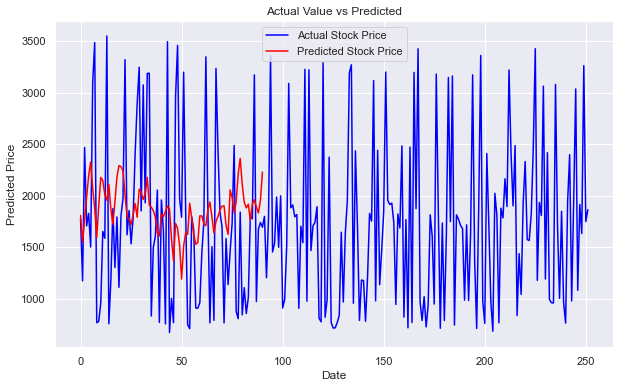

In [79]:
plt.figure(figsize=(10,6))
plt.plot(open_testing_processed, color='blue', label='Actual Stock Price')
plt.plot(predictions , color='red', label='Predicted Stock Price')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

In [110]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [111]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [112]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [113]:
# IMPORTING DATASET 
dataset = dataset_ex_df.reindex(index = dataset_ex_df.index[::-1])

In [114]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [86]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

<ipython-input-86-a26fa49f9c41>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  OHLC_avg = dataset.mean(axis = 1)


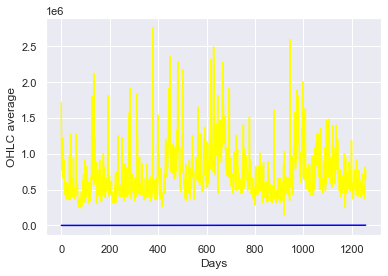

In [87]:
# PLOTTING All INDICATORS IN PLOT
plt.plot(OHLC_avg, 'yellow', label = 'OHLC avg')
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('OHLC average')
plt.show()

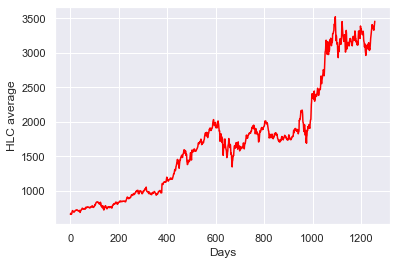

In [88]:
plt.plot(HLC_avg, 'red', label = 'HLC avg')
plt.xlabel('Days')
plt.ylabel('HLC average')
plt.show()

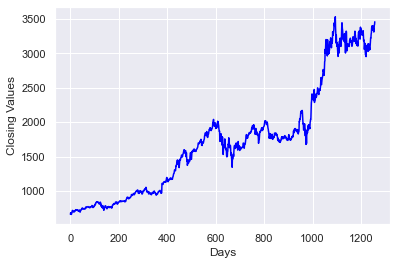

In [89]:
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.show()

In [109]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [91]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [92]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [93]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [94]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [95]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mae']) # Try mae, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
941/941 - 16s - loss: 0.0478 - mae: 0.1701
Epoch 2/50
941/941 - 3s - loss: 0.0322 - mae: 0.1232
Epoch 3/50
941/941 - 3s - loss: 0.0262 - mae: 0.1063
Epoch 4/50
941/941 - 3s - loss: 0.0230 - mae: 0.0998
Epoch 5/50
941/941 - 3s - loss: 0.0212 - mae: 0.0970
Epoch 6/50
941/941 - 3s - loss: 0.0201 - mae: 0.0959
Epoch 7/50
941/941 - 3s - loss: 0.0194 - mae: 0.0957
Epoch 8/50
941/941 - 2s - loss: 0.0190 - mae: 0.0958
Epoch 9/50
941/941 - 3s - loss: 0.0187 - mae: 0.0963
Epoch 10/50
941/941 - 3s - loss: 0.0186 - mae: 0.0966
Epoch 11/50
941/941 - 3s - loss: 0.0185 - mae: 0.0970
Epoch 12/50
941/941 - 3s - loss: 0.0184 - mae: 0.0972
Epoch 13/50
941/941 - 3s - loss: 0.0183 - mae: 0.0975
Epoch 14/50
941/941 - 3s - loss: 0.0183 - mae: 0.0978
Epoch 15/50
941/941 - 3s - loss: 0.0182 - mae: 0.0980
Epoch 16/50
941/941 - 3s - loss: 0.0182 - mae: 0.0982
Epoch 17/50
941/941 - 3s - loss: 0.0182 - mae: 0.0983
Epoch 18/50
941/941 - 3s - loss: 0.0181 - mae: 0.0985
Epoch 19/50
941/941 - 3s - loss: 0.0

In [104]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

ValueError: Data cardinality is ambiguous:
  x sizes: 313
  y sizes: 1
Make sure all arrays contain the same number of samples.

In [105]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [106]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

ValueError: Found array with dim 3. Estimator expected <= 2.

In [107]:
# TRAINING rmse
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train : %.2f' % (trainScore))
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train : 346289.19
Test RMSE: 660771.31


In [108]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

NameError: name 'testPredictPlot' is not defined

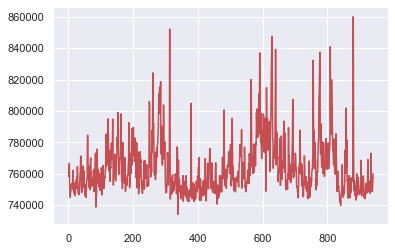

In [101]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Trend of training and prediction data')
plt.show()

In [ ]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)